<a href="https://colab.research.google.com/github/mflagosv25/Talento-Tech/blob/main/Proyecto_Final/Clasificacion_TextosNormativos_Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Identificación de IRPC en documentos normativos, mediante modelos de aprendizaje supervisado**

### C8 Inteligencia Artificial_Nivel Integrador_G1
---


# **Introducción**

Este proyecto surge como respuesta a una necesidad crítica del equipo de Clic Participativo del DNP: la identificación y clasificación automática de documentos regulatorios que se relacionen con la creación, modificación o eliminación de Instancias de reglamentarias de participación ciudadana (IRPC). El proceso manual de búsqueda de estos documentos es una tarea tediosa y altamente consumidora de tiempo debido a la gran cantidad de documentos normativos que se generan mensualmente en el país.

En este contexto, se optó por la aplicación de algoritmos de procesamiento de texto en conjunco con modelos supervisados de Machine Learning. La metodología propuesta se basa en utilizar los documentos, previamente etiquetados por el equipo de Clic Participativo para entenar los modelos de clasificación, y con ellos clasificar los nuevos documentos normativos que se van generando. Esta metodología, simplifica de manera considerable las labores del equipo, permitiéndoles acceder eficazmente a los documentos pertinentes y liberándolos de la laboriosa tarea de búsqueda y clasificación manual de documentos

# **Objetivo general**
Implementar un modelo de clasificacón de los documentos normativos que se generan en el país, buscando mejorar el proceso previo para la actualización del visualizador (Clic Participativo) de las instancias reglamentadas de participación ciudadana (IRPC), de manera que facilite su consulta y análisis por parte de la ciudadanía y los demás actores que participan en estas instancias de conformación, ejercicio y control del poder político.

# **Metodología**

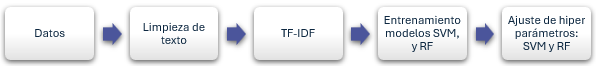

Para alcanzar los objetivos de este proyecto, se implementó la siguiente metodología:

**1.	Preparación de los datos de entrenamiento**
Se inicia realizando la revisión exploratoria de datos, además de su preparación y preprocesamiento. Enseguida se procede a implementar un script en Python, con el fin de cruzar los documentos normativos etiquetados como IRPC, por el equipo de expertos, con la base de Datos total, mediante el nombre de cada uno de los documentos, con esto tenemos la base de datos total, con su respectiva etiqueta la cual indica si cada documento se relaciona o no con IPC.

**2.	Vectorización y procesamiento de los datos de entrada**
Para representar los textos de manera que puedan ser procesados por el modelo de machine learning, inicialmente se realiza la tokenización y normalización del contenido textual de cada documento (conversión a minúsculas, eliminación de signos de puntuación, etc.) para mejorar la consistencia de los datos, luego de esto se procede a eliminar palabras comunes y sin valor predictivo (stopwords) para reducir el ruido en los datos, finalmente se seleccionó la técnica de vectorización TF-IDF para convertir los documentos en vectores numéricos.

**3.	Selección del modelo**
Para la clasificación de los documentos se consideraron varios modelos de aprendizaje supervisado. Los principales pasos fueron:

•	Exploración de Modelos: Se evaluaron varios algoritmos de clasificación como la Regresión Logística, Máquinas de Vectores de Soporte (SVM) y Árboles de Decisión

•	Criterios de Selección: Se eligió el modelo que mostró mejor precisión, exhaustividad y F1-score en las pruebas preliminares, considerando el desbalance de clases.

•	Manejo del Desbalance de Clases: Se utilizaron técnicas como el sobre muestreo de la clase minoritaria y submuestrei de la clase mayoritaria, para mejorar el desempeño en la clase menos representada que corresponde a los documentos normativos que se relacionan con Instancias de Participación Ciudadana.

**4.	Pruebas de desempeño y ajuste de hiper parámetros**
Se implementó una optimización del modelo seleccionado para mejorar su precisión en la clasificación de documentos, para lo cual inicialmente se utilizó validación cruzada para garantizar la consistencia en los resultados y reducir el sesgo. Para el ajuste de hiper parámetros se empleó las técnicas de búsqueda en malla (Grid Search) para encontrar los valores óptimos de los hiper parámetros.

Finalmente se evaluó el modelo usando métricas como precisión, exhaustividad, F1-score, asegurando un equilibrio entre precisión y sensibilidad.


In [ ]:
import pickle as pk
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from google.colab import drive

In [ ]:
#Montar path para acceder a la cararpeta de los archivos de google Drive
drive.mount("/content/gdrive/")
work_path = "/content/gdrive/My Drive/Proyecto_TalentoTech"
sys.path.insert(0,work_path)

Mounted at /content/gdrive/


In [ ]:
#%% Funciones principales
def load_dataset():
    print("Cargando dataset etiquetado"+"..."+"\n")
    with open(f"{work_path}/train_data_1S2024.pkl",'rb') as archivo:
        df = pk.load(archivo)
    return df

def balance_clases(df,mult):
    df_1 = df[df['etiqueta']==1]
    df_0 = df[df['etiqueta']==0]
    df_0s = df_0.drop_duplicates(subset=['data'], keep='first')
    #df_0s = muestra_estratificada(df_0s,'anio',0.1)
    df_0s = df_0s.sample(n=len(df_1)*mult,random_state=42)
    df_bal = pd.concat([df_0s,df_1]).reset_index(drop = True)
    return df_bal

def particion_datos(df):
    X = list(df["data"])
    y = list(df["etiqueta"])
    print("spliting data ... \n")
    # dejando un 20% para probar el desempeño
    # Implementamos un Muestreo estratificado, para garantizar muestras de 1 y 0
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state=42)
    print(f"Proporción en y_train: {pd.Series(ytrain).value_counts(normalize=True)}")
    print(f"Proporción en y_test: {pd.Series(ytest).value_counts(normalize=True)}")
    return Xtrain, Xtest, ytrain, ytest

def vectorizar(Xtrain, Xtest):
    # TFIDF parameters
    max_features = 5000

    tfidf = TfidfVectorizer(
        encoding="utf-8",
        stop_words=None,
        lowercase=False,
        max_features=max_features # Ajustar
    )
    Xtrain_vec = tfidf.fit_transform(Xtrain)
    Xtest_vec = tfidf.transform(Xtest)
    return Xtrain_vec, Xtest_vec, tfidf

def over_sampling(Xtrain_vec, ytrain):
    print("\nobersampling the training data...\n")
    oversampler = SMOTE(random_state = 42)
    Xtrain_res, ytrain_res = oversampler.fit_resample(Xtrain_vec,
                                                      ytrain)
    return Xtrain_res, ytrain_res

def obtener_reporte(model,Xtest_vec,ytest):
    print('obteniendo predicciones ...')
    y_pred = model.predict(Xtest_vec)
    print("The test accuracy is: ")
    print(accuracy_score(ytest, y_pred))
    # classification report
    print("")
    print("Classification report")
    print(classification_report(ytest, y_pred))
    return y_pred

def obtener_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    f_p = cm[0,1]
    print("Total de falsos positivos:", f_p)
    # Crea la gráfica
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.ylabel("Valores Reales")
    plt.xlabel("Valores Predichos")
    plt.show()

def guardar_modelo(pipeline):
    print("saving model...")
    ts = ""
    with open(".\\models\\" + ts + "-final_model_s_ns.pkl", "wb") as output:
        pk.dump(pipeline, output)
    print("Done!")


In [ ]:
#Carga y adecuación de los datos
data = load_dataset()
data = data[data["data"].apply(len) > 0]
# Balanceo y adecuación de las categorías
mult = 20 # cantidad de veces la cantidad de datos de la categoría 1, para muestrear datos de la categoría 0
df = balance_clases(data,mult)
# Partición datos
Xtrain, Xtest, ytrain, ytest = particion_datos(df)
Xtrain_vec, Xtest_vec, vectorizador = vectorizar(Xtrain,Xtest)
# Generar Datos sintéticos
Xtrain_res, ytrain_res = over_sampling(Xtrain_vec, ytrain)

Cargando dataset etiquetado...

spliting data ... 

Proporción en y_train: 0    0.95218
1    0.04782
Name: proportion, dtype: float64
Proporción en y_test: 0    0.953184
1    0.046816
Name: proportion, dtype: float64

obersampling the training data...



In [ ]:
data[['ids','nombre','anio','data','etiqueta']].head()

,ids,nombre,anio,data,etiqueta
0,..\..\Insumos/txt_planos_91-2014\D0001000.txt,decreto numero 1 de 2000,2000,modifican decretos republica facultades consti...,0
1,..\..\Insumos/txt_planos_91-2014\D0001001.txt,decreto numero 1 de 2001,2001,suprime promotora vacaciones recreacion prosoc...,0
2,..\..\Insumos/txt_planos_91-2014\D0001008.txt,decreto numero 1 de 2008,2008,reglamenta relacionado subsidio adecuacion rep...,0
3,..\..\Insumos/txt_planos_91-2014\D0001_93.txt,decreto numero 1 de 1993,1993,reglamenta codigo republica facultades confier...,0
4,..\..\Insumos/txt_planos_91-2014\D0001_94.txt,decreto numero 0001 de 1994,1994,incorporaciones republica facultades confiere ...,0


In [ ]:
# Instancia y entenamiento del Modelo SVM
C = 0.7
kernel = "rbf"
gamma = "scale"
class_weight = "balanced"
model = SVC(
    C=C,
    gamma=gamma,
    class_weight=class_weight,
    kernel=kernel
)
print("generando los modelos ...\n")
model.fit(Xtrain_res, ytrain_res)

generando los modelos ...



SVC(C=0.7, class_weight='balanced')

In [ ]:
#Instancia y entenamiento del Modelo Ramdom Forest

Class_weight = 'balanced'
Max_depth = 24
Min_samples_split = 15
N_estimators = 100
model_rf = RandomForestClassifier(
    class_weight= Class_weight,
    #max_depth = Max_depth,
    #min_samples_split = Min_samples_split,
    n_estimators = N_estimators,
    random_state=42,
    )
model_rf.fit(Xtrain_res, ytrain_res)

RandomForestClassifier(class_weight='balanced', random_state=42)

- - - - - Resultado para etiquetas: 20 veces
etiqueta
0    2540
1     127
Name: count, dtype: int64
- - - - - 
-------- SVM --------
obteniendo predicciones ...
The test accuracy is: 
0.9756554307116105

Classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       509
           1       0.88      0.56      0.68        25

    accuracy                           0.98       534
   macro avg       0.93      0.78      0.84       534
weighted avg       0.97      0.98      0.97       534

Total de falsos positivos: 2


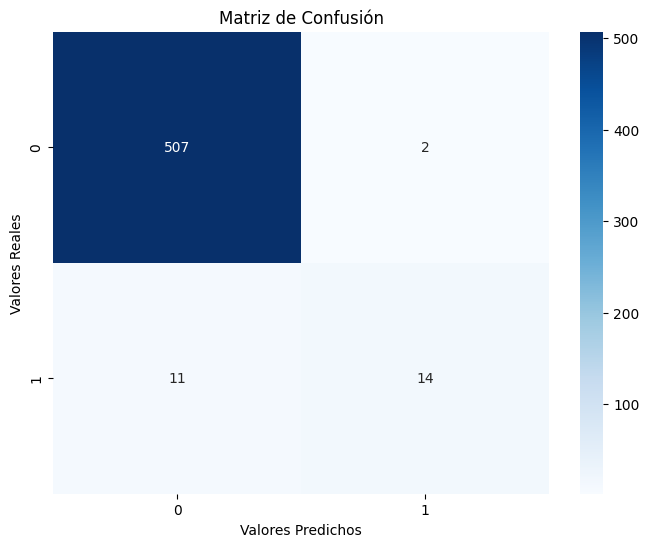

In [ ]:
#Mostrando el desempeño del modelo SVM
print('- '*5+f"Resultado para etiquetas: {mult} veces\n{df['etiqueta'].value_counts()}\n"+
      '- '*5)
print("-------- SVM --------")
y_pred = obtener_reporte(model,Xtest_vec,ytest)
obtener_cm(ytest, y_pred)

-------- RF --------
obteniendo predicciones ...
The test accuracy is: 
0.9775280898876404

Classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       509
           1       0.88      0.60      0.71        25

    accuracy                           0.98       534
   macro avg       0.93      0.80      0.85       534
weighted avg       0.98      0.98      0.98       534

Total de falsos positivos: 2


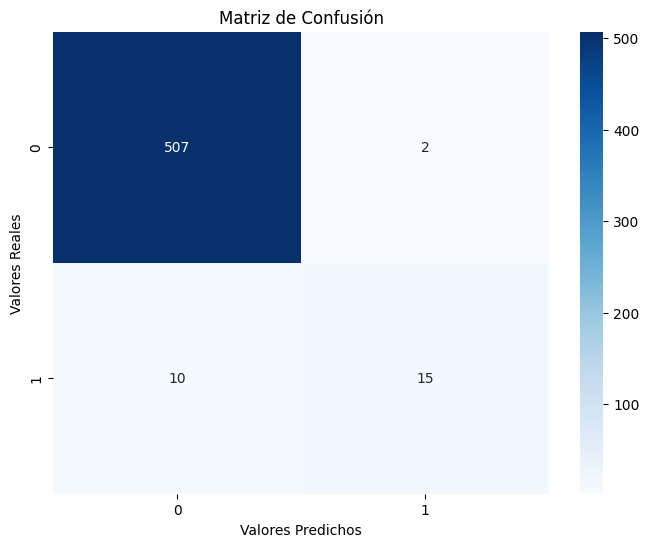

In [ ]:
#%% Mostrando el desempeño del modelo RF
print("-------- RF --------")
y_pred_rf = obtener_reporte(model_rf,Xtest_vec,ytest)
obtener_cm(ytest, y_pred_rf)

# Conclusiones

•	El principal reto de este proyecto, fué la presencia de un fuerte despalance en las categorías, debido a que del total de los documentos normatimos existentes en el pais, son muy pocos los documentos que se relacionan con instancias de participación ciudadana, este debalance hace que los modelos tengan un fuerte sesgo hacia la clase mayoritaria.

•	Se evaluaron varios algoritmos de clasificación como la Regresión Logística, Máquinas de Vectores de Soporte (SVM) y Árboles de Decisión

•	El modelo Random Forest mostró mejor precisión, exhaustividad y F1-score en las pruebas preliminares, considerando el desbalance de clases.

•	Con las técnicas para manejo de desbalance de clases se logró mejorar el desempeño en la clase menos representada que corresponde a los documentos normativos que se relacionan con Instancias de Participación Ciudadana, pues se pasó de tener porcentajes de 40% a cerca del 70% para el F1-Score

•	Se logró cumplir con el objetivo planteado, pues con la metodología que actualmente se implementa (algoritmo de búsqueda), se tenía un desempeño de alrededor de 10% para F1-Score, y pasamos a tener un desempeño alrededor del 70% para esta métrica.

# Bibliografía:


*   Imprenta nacional de Colombia https://www.imprenta.gov.co/

*   Visor Clic Participativo https://app.powerbi.com/view?r=eyJrIjoiYTU1ODU0MzItMDQ5OS00NWUyLWJhZjgtOTFiMzhmZWEwY2NhIiwidCI6IjA0MjYwZTIwLTIzNGMtNGM5Zi1hOWRkLTc5Mjg2YjFiNzBhYyIsImMiOjR9&pageName=ReportSectionfb21e9033cd1f48b7eff

*   Dirección de Desarrollo Digital, Departamento Nacional de Planeación https://www.dnp.gov.co/LaEntidad_/subdireccion-general-prospectiva-desarrollo-nacional/direccion-desarrollo-digital



